# Author

#### Student Name : Harsh Malik
#### Student ID : 230260898

# Problem Formulation

Using the MLEnd Yummy Dataset, build a machine learning pipeline that takes as an input a photo of a dish that has either rice or chips and predicts whether the picture has rice or chips. The interesting part of this project is that we are effectively using the images of dishes to identify whether the dish consists of Rice or Chips from the dataset that we have where each dish has either Rice or Chips in it. This model can actually be used to identify different kinds of ingredients present inside a dish just by looking at the picture of dish. It will be really helpful in systems that will tell users whether the food item that they have the image of contains ingredients that might have allergens, or if someone wishes to just find out what ingredients are used for a certain dish, this model will be helpful there as well.

## Machine Learning Pipeline

In [2]:
!pip install mlend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spkit as sp

from skimage import exposure
from skimage.color import rgb2hsv, rgb2gray
import skimage as ski

import mlend
from mlend import download_yummy, yummy_load

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

In [5]:
subset = {}
datadir = download_yummy(save_to = '/content/drive/MyDrive/Data/MLEnd_basic', subset = subset,verbose=1,overwrite=False)

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|3250\3250|003250.jpg
Done!


I have chosen to extract the different data points from the dataframe based on the 'Ingredients' feature because the features we wish to test our model on, Rice and Chips are nothing but part of the ingredients of the dishes present in the dataset we have. Hence this will give us exactly the desired dataset which can be used to train and test the model we will build.

In [6]:
os.listdir(datadir)

['MLEndYD_images', 'MLEndYD_image_attributes_benchmark.csv']

In [132]:
TrainSet, TestSet, Map = yummy_load(datadir_main=datadir,train_test_split='Benchmark_A')

Total 3250 found in /content/drive/MyDrive/Data/MLEnd_basic/yummy/MLEndYD_images/


In [133]:
display(TrainSet['Y'])

,Diet,Cuisine,Home_or_restaurant,Healthiness_rating,Likeness,Dish_name,Ingredients,Healthiness_rating_int,Likeness_int
0,non_vegetarian,japanese,marugame_udon,neutral,like,chicken_katsu_rice,"rice,chicken_breast,spicy_curry_sauce",3.0,4.0
1,non_vegetarian,english,home,unhealthy,like,english_breakfast,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",2.0,4.0
2,non_vegetarian,chinese,jinli_flagship_branch,neutral,strongly_like,spicy_chicken,"chili,chicken,peanuts,sihuan_peppercorns,green...",3.0,5.0
3,vegetarian,indian,home,unhealthy,strongly_like,gulab_jamun,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",2.0,5.0
4,non_vegetarian,indian,home,healthy,strongly_like,chicken_masala,"chicken,lemon,turmeric,garam_masala,coriander_...",4.0,5.0
...,...,...,...,...,...,...,...,...,...
3243,vegetarian,italian,home,healthy,neutral,khichdi,"rice,split_yellow_mung_beans,salt,cumin_seeds,...",4.0,3.0
3244,non_vegetarian,italian,home,neutral,strongly_like,spaghetti_bolognese,"olive_oil,beef_mince,onion,carrot,celery,garli...",3.0,5.0
3245,vegetarian,indian,home,healthy,strongly_like,zeera_rice,"1_cup_basmati_rice,2_cups_water,2_tablespoons_...",4.0,5.0
3248,vegan,indian,home,very_healthy,strongly_like,fruit_milk,"kiwi,banana,apple,milk",5.0,5.0


Here, we basically extract the data points that contain either Rice or Chips from the Training dataset we have received using the 'yummy_load' function.

To achieve this, we have used the 'Ingredient' feature as it contains the ingredients of every dish present in the dataset. This effectively helps us extract dishes containing rice and chips.

*************************************
Step 1: Reset the index of the TrainSet['Y'] dataframe so we can use it later to extract the correct images corresponding to the data points we will extract containing rice and chips.

Step 2: Extract the indices of dataframe containing Rice and Chips by using 'str.findall()' function on the 'Ingredients' feature in TrainSet['Y'].

Step 3: Using a for loop, iterate over the dataframe and append 'True' or 'False' in a list called 'indexes' based on whether the 'str.findall()' function found the desired ingredient on that data point or not. Also, for every 'True' value found, append that particular index number to another list called 'true_index' which will be used later to simply extract the correct 'X_paths' values corresponding to the datapoints extracted.

Step 4: Using the True-False 'indexes' list, collect the desired data points.

Step 5: Using the 'true_index' list, extract the corresponding paths to the images of each dish we have extracted to be used for training the model.

In [134]:
TrainSet['Y'].reset_index(inplace = True)
points = TrainSet['Y']['Ingredients'].str.findall('chips|fries|rice')
indexes = []
true_index = []
for i in range(len(points)):
  if points[i] == []:
    indexes.append(False)
  else:
    true_index.append(i)
    indexes.append(True)

TrainSet['Y'] = TrainSet['Y'][indexes]
list1 = [TrainSet['X_paths'][i] for i in true_index]
TrainSet['X_paths'] = list1

In [136]:
display(TrainSet['Y'])

,index,Diet,Cuisine,Home_or_restaurant,Healthiness_rating,Likeness,Dish_name,Ingredients,Healthiness_rating_int,Likeness_int
0,0,non_vegetarian,japanese,marugame_udon,neutral,like,chicken_katsu_rice,"rice,chicken_breast,spicy_curry_sauce",3.0,4.0
12,20,non_vegetarian,asian,home,healthy,strongly_like,biryani,"mutton,rice,onion,tomato,red_chilli_powder,sal...",4.0,5.0
13,21,vegetarian,indian,home,very_healthy,neutral,rice_beetroot_curry,"rice,beetroot,salt,spices",5.0,3.0
14,23,vegan,british,home,neutral,like,pie_and_chips,"mushroom_pie,chips,peas",3.0,4.0
16,25,non_vegetarian,pakistani,home,healthy,strongly_like,chicken_biryani,"rice,chicken,biryani_masala,yogurt,oil,green_c...",4.0,5.0
...,...,...,...,...,...,...,...,...,...,...
2260,3228,vegetarian,south_indian,home,healthy,like,lemon_rice,"rice,onion,chilli,turmeric_powder,tomato,salt,...",4.0,4.0
2265,3235,non_vegetarian,german_turkish,gdk,unhealthy,strongly_like,german_doner_kebab,"lettuce,tomato,onion,red_cabbage,bread,yoghurt...",2.0,5.0
2269,3242,vegetarian,british,restaurant,healthy,dislike,pan-fried_beef_with_rice,"rice,corn,beef,red_cabbage",4.0,2.0
2270,3243,vegetarian,italian,home,healthy,neutral,khichdi,"rice,split_yellow_mung_beans,salt,cumin_seeds,...",4.0,3.0


Now, we add another column/feature called 'Rice_Chips' where we simply encode 2 different values for both, Rice and Chips. Here, we have chosen value 0 for dishes containing rice and value 1 for dishes containing chips.

In [137]:
TrainSet['Y']['Rice_Chips'] = ''
TrainSet['Y'].loc[TrainSet['Y']['Ingredients'].str.contains('rice'), 'Rice_Chips'] = 0
TrainSet['Y'].loc[TrainSet['Y']['Ingredients'].str.contains('chips|fries'), 'Rice_Chips'] = 1
TrainSet['Y']

,index,Diet,Cuisine,Home_or_restaurant,Healthiness_rating,Likeness,Dish_name,Ingredients,Healthiness_rating_int,Likeness_int,Rice_Chips
0,0,non_vegetarian,japanese,marugame_udon,neutral,like,chicken_katsu_rice,"rice,chicken_breast,spicy_curry_sauce",3.0,4.0,0
12,20,non_vegetarian,asian,home,healthy,strongly_like,biryani,"mutton,rice,onion,tomato,red_chilli_powder,sal...",4.0,5.0,0
13,21,vegetarian,indian,home,very_healthy,neutral,rice_beetroot_curry,"rice,beetroot,salt,spices",5.0,3.0,0
14,23,vegan,british,home,neutral,like,pie_and_chips,"mushroom_pie,chips,peas",3.0,4.0,1
16,25,non_vegetarian,pakistani,home,healthy,strongly_like,chicken_biryani,"rice,chicken,biryani_masala,yogurt,oil,green_c...",4.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2260,3228,vegetarian,south_indian,home,healthy,like,lemon_rice,"rice,onion,chilli,turmeric_powder,tomato,salt,...",4.0,4.0,0
2265,3235,non_vegetarian,german_turkish,gdk,unhealthy,strongly_like,german_doner_kebab,"lettuce,tomato,onion,red_cabbage,bread,yoghurt...",2.0,5.0,1
2269,3242,vegetarian,british,restaurant,healthy,dislike,pan-fried_beef_with_rice,"rice,corn,beef,red_cabbage",4.0,2.0,0
2270,3243,vegetarian,italian,home,healthy,neutral,khichdi,"rice,split_yellow_mung_beans,salt,cumin_seeds,...",4.0,3.0,0


Now, we repeat the same process described above on the TestSet as well.

In [138]:
TestSet['Y'].reset_index(inplace = True)
points = TestSet['Y']['Ingredients'].str.findall('chips|fries|rice')
indexes = []
true_index = []
for i in range(len(points)):
  if points[i] == []:
    indexes.append(False)
  else:
    true_index.append(i)
    indexes.append(True)

TestSet['Y'] = TestSet['Y'][indexes]
list1 = [TestSet['X_paths'][i] for i in true_index]
TestSet['X_paths'] = list1

In [139]:
TestSet['Y']['Rice_Chips'] = ''
TestSet['Y'].loc[TestSet['Y']['Ingredients'].str.contains('rice'), 'Rice_Chips'] = 0
TestSet['Y'].loc[TestSet['Y']['Ingredients'].str.contains('chips|fries'), 'Rice_Chips'] = 1
TestSet['Y']

,index,Diet,Cuisine,Home_or_restaurant,Healthiness_rating,Likeness,Dish_name,Ingredients,Healthiness_rating_int,Likeness_int,Rice_Chips
4,15,vegan,indian,home,healthy,neutral,khichdi,"rice,spices,herbs",4.0,3.0,0
7,19,vegetarian,indian,home,healthy,like,lentil-based_vegetable_stew_with__rice,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,4.0,4.0,0
12,37,non_vegetarian,indian,home,healthy,strongly_like,rice_with_chicken_curry,"boiled_rice,chicken,sunflower_oil,chilli_powde...",4.0,5.0,0
13,38,vegetarian,south_indian,home,very_healthy,like,khichidi,"rice,moong_lentils,ghee,cumin_seeds,ginger",5.0,4.0,0
14,39,non_vegetarian,indian,restaurant,neutral,strongly_like,chicken_biryani,"rice,chicken,potatos_and_spicy,",3.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...
958,3187,vegetarian,indian,home,neutral,strongly_like,bhel,"puffed_rice,tamarind_chutney,green_chilli_past...",3.0,5.0,0
959,3198,vegetarian,asian,restaurant,neutral,strongly_dislike,red_beans_&_rice,"red_beans,rice,mayonaise,corn,lettuce,tomatoes...",3.0,1.0,0
961,3201,non_vegetarian,japanese,marugame_udon,neutral,strongly_like,chicken_teriyaki_rice,"rice,chicken_thigh,sweet_and_sticky_teriyaki_s...",3.0,5.0,0
968,3233,vegetarian,indian,home,very_healthy,strongly_like,rasam_rice,"garlic,curry_leaves,green_chilli,cumin,black_p...",5.0,5.0,0


Separating the 'X_paths' and encoded feature ('Rice_Chips') for both Training and Testing dataset.

In [192]:
X_train_paths = TrainSet['X_paths']
X_test_paths  = TestSet['X_paths']

Y_train = np.array(TrainSet['Y']['Rice_Chips'].astype('int'))
Y_test  = np.array(TestSet['Y']['Rice_Chips'].astype('int'))

Checking the dataset we have collected from our original dataset by printing the images of the dishes contining Rice or Chips. This is done just to verify whether we have achieved the result we desired or not.

Rice


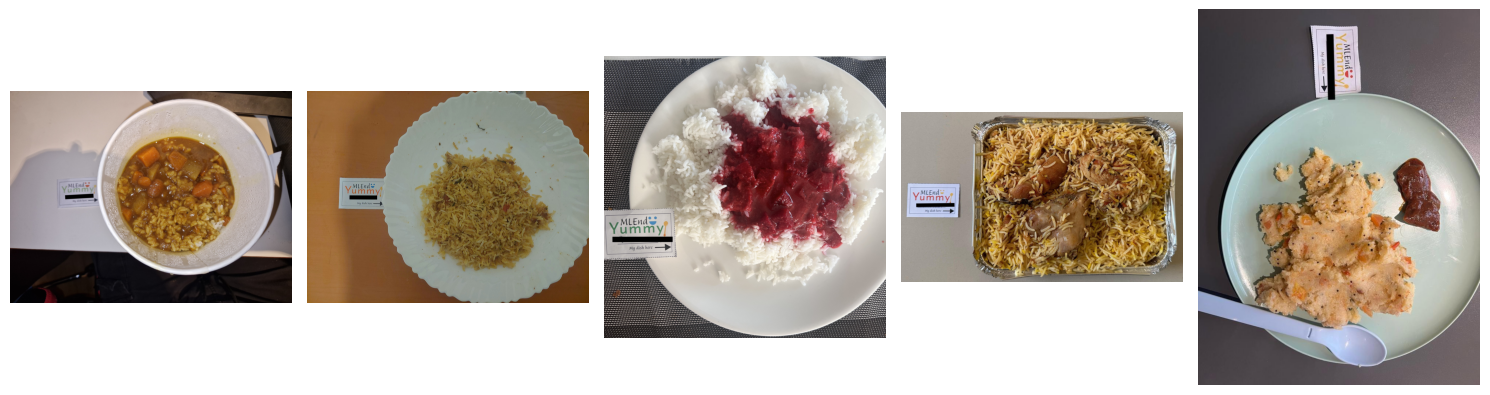

Chips


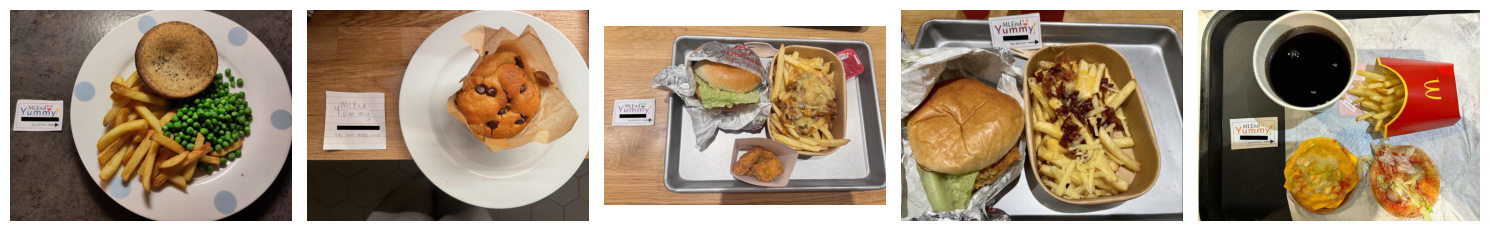

In [144]:
Chips_Img = np.array(X_train_paths)[Y_train==1]
Rice_Img = np.array(X_train_paths)[Y_train==0]

print('Rice')
plt.figure(figsize=(15,5))
for k,file in enumerate(Rice_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

print('Chips')
plt.figure(figsize=(15,5))
for k,file in enumerate(Chips_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

## Transformation Stage

Since the images that we have are in different sizes, we need to standardise it to bring each image into the same dimensions space. We can achieve this by changing the dimensions of all the images in our dataset to one standard size. Here we have converted each image into a standard size of 200 x 200 x 3, or to put it in simpler terms, we have changed all images into a square image. That is, all images now have the same dimension.

In [145]:
def make_it_square(I, pad=0):
  N,M,C = I.shape
  if N>M:
    Is = [np.pad(I[:,:,i], [(0,0),(0, N-M)], 'constant', constant_values=pad) for i in range(C)]
  else:
    Is = [np.pad(I[:,:,i], [(0, M-N),(0,0)], 'constant', constant_values=pad) for i in range(C)]

  return np.array(Is).transpose([1,2,0])

def resize_img(I,size=[100,100]):
  N,M,C = I.shape
  Ir = [sp.core.processing.resize(I[:,:,i],size) for i in range(C)]
  return np.array(Ir).transpose([1,2,0])

Converting the training and testing images.

In [146]:
X_train = []
for k,file in enumerate(X_train_paths):
  sp.utils.ProgBar_JL(k,len(X_train_paths),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_train.append(I)


X_test = []
for k,file in enumerate(X_test_paths):
  sp.utils.ProgBar_JL(k,len(X_test_paths),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_test.append(I)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_train.shape, X_test.shape

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|584\584|
Done!
100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|268\268|
Done!


((584, 200, 200, 3), (268, 200, 200, 3))

Viewing the result obtained by performing the operations described above.

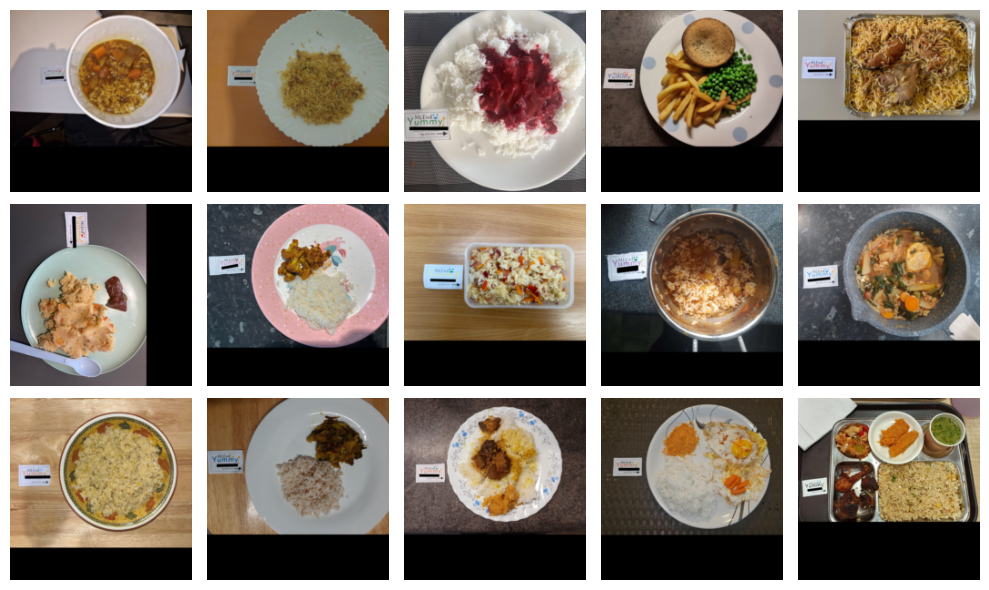

In [147]:
plt.figure(figsize=(10,6))
for k,I in enumerate(X_train):
  plt.subplot(3,5,k+1)
  plt.imshow(I)
  plt.axis('off')
  k+=1
  if k>=15:break
plt.tight_layout()
plt.show()

In the following piece of code, we reduce the dimensionality of all the pictures within our dataset from 200 x 200 x 3 = 120000 dimension to 3 dimensions. To achieve this task, we use 2 functions.

****************************************************************

The first function 'get_yellow_component()' simply converts our input image from an RGB image to HSV image. HSV images provide us with 3 values:

Hue (H) : It defines the dominant wavelength of the color in the pixel.

Saturation (S) : This feature defines the purity of the color that we have on scale of 0 to 1. 0 being a shade of gray and 1 being the most vivid possible color shade.

Value (V) : This defines the brighestness of the color. It ranges from 0 to 1, 0 being black and 1 being the maximum possible brightness of the color.

We have multiplied the values received after conversion of our image by 255 to get the values in the range of 0 to 255 from 0 to 1. We then multiply the hue values received which greater than t1 and less than t2 as this range defines the yellow color part of the image. All the values are then added and returned as a feature of the image.

***************************************************************
The second function 'GMLC_features()' takes as input and RGB image and converts it to a grayscale image. The values obtained are then multiplied by 255 to normalise it in the range 0 to 255. We then compute the gray-level co-occurrence matrix (GLCM) using the 'graycomatrix()' function on the converted image with a distance = 5 pixel and angle = 0 degrees. This matrix provides us with 2 new features, namely:

f1 (Dissimilarity) : A measure of the average absolute difference between pixel values for pixel pairs with a specified offset.

f2 (Correlation) : A measure of the linear dependence of pixel values in the specified direction.

These 2 features are then returned by the function in the end.

In [206]:
from skimage.feature import ORB
from skimage.feature import graycomatrix, graycoprops


def get_yellow_component(I,t1=27, t2=33):
  Ihsv = (rgb2hsv(I)*255).astype('int')
  mask = (Ihsv[:,:,0]<t2)*(Ihsv[:,:,0]>t1)
  Ypx = mask.sum()
  return Ypx

def GMLC_features(I):
  Ig = (rgb2gray(I)*255).astype('int')
  glcm = graycomatrix(Ig, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
  f1 = graycoprops(glcm, 'dissimilarity')[0, 0]
  f2 = graycoprops(glcm, 'correlation')[0, 0]
  return f1,f2

Now we extract features from both, our training dataset images and our testing dataset images using the 2 functions defined above and append the values in a new list which we will use further to train our model.

In [163]:
X_train_f = []
for k, I in enumerate(X_train):
  f1 = get_yellow_component(I)
  f2,f3 = GMLC_features(I)
  X_train_f.append([f1,f2,f3])

X_test_f = []
for k, I in enumerate(X_test):
  f1 = get_yellow_component(I)
  f2,f3 = GMLC_features(I)
  X_test_f.append([f1,f2,f3])

Converting our lists to numpy arrays and printing the shape of these arrays to show that we have achieved exactly what we wished for; dimensionality reduction from 120000 to just 3 features. This can be seen from the shape of the numpy array we have received.

In [164]:
X_train_f = np.array(X_train_f)
X_test_f = np.array(X_test_f)
X_train_f.shape, X_test_f.shape

((584, 3), (268, 3))

In the following piece of code, we simply normalise the values received by subtracting the mean of the features from every feature and dividing them by their standard deviation. This is done to ensure that all the values received are in the same range.

In [165]:
MEAN = X_train_f.mean(0)
SD = X_train_f.std(0)

X_train_fn = (X_train_f - MEAN)/SD
X_test_fn = (X_test_f - MEAN)/SD

## Modelling

We will use two different models here for this project, namely The Linear Support Vector Machines (Linear SVM) and Random Forest Classifier.

*****************
The Linear SVM is a simple classification model which separates the classes linearly. I have chosen this model to check whether the it is possible to separate the dishes containing Rice or Chips linearly. It is very simple to implement and is fast as well.
*****************
The Random Forest Classifier is the second model I have chosen because it is more complex and capable of classifying different classes even when they are not linearly separable. Therefore it adds more flexibility to the model and can capture highly non linear relationships as well.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

model1 = LinearSVC(C=0.5)
model1.fit(X_train_fn, Y_train)

model2 = RandomForestClassifier(n_estimators=5,max_depth=3)
model2.fit(X_train_fn, Y_train)

NameError: ignored

In [213]:
ytp1 = model1.predict(X_train_fn)
ysp1 = model1.predict(X_test_fn)

train_accuracy_LinearSVM = np.mean(ytp1==Y_train)
test_accuracy_LinearSVM  = np.mean(ysp1==Y_test)

print('Results obtained using Linear SVM Model :')
print('Training Accuracy:\t',train_accuracy_LinearSVM)
print('Test Accuracy:\t',test_accuracy_LinearSVM)
print('\n')
ytp2 = model2.predict(X_train_fn)
ysp2 = model2.predict(X_test_fn)

train_accuracy_RandomF = np.mean(ytp2==Y_train)
test_accuracy_RandomF  = np.mean(ysp2==Y_test)

print('Results obtained using Random Forest Classifier Model :')
print('Training Accuracy:\t',train_accuracy_RandomF)
print('Test Accuracy:\t',test_accuracy_RandomF)

Results obtained using Linear SVM Model :
Training Accuracy:	 0.910958904109589
Test Accuracy:	 0.8992537313432836


Results obtained using Random Forest Classifier Model :
Training Accuracy:	 0.910958904109589
Test Accuracy:	 0.8992537313432836


In [207]:
def showConfMat(CM, labels = ['Chips','Rice']):
  plt.matshow(CM,cmap='Blues')
  for i in range(CM.shape[0]):
    for j in range(CM.shape[1]):
      plt.text(i,j,CM[i,j].round(2),ha='center',)
  plt.xticks([0,1],labels)
  plt.yticks([0,1],labels)
  plt.show()

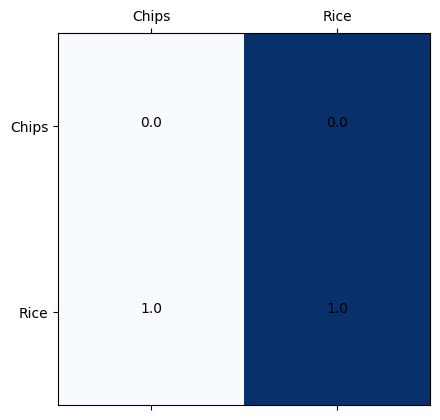

In [204]:
Ac = np.mean(ysp[Y_test.astype(int)==1]==1)
Ar = np.mean(ysp[Y_test.astype(int)==0]==0)

Mc = np.mean(ysp[Y_test.astype(int)==1]==0)
Mr = np.mean(ysp[Y_test.astype(int)==0]==1)

CM = np.array([[Ac, Mc],[Mr, Ar]])

showConfMat(CM)

In [205]:
TrainSet['Y']['Rice_Chips'].value_counts()

0    532
1     52
Name: Rice_Chips, dtype: int64